In [1]:
#!pip install google-cloud-bigquery pandas db-dtypes google-cloud-bigquery-storage
import os
from google.cloud import bigquery
import pandas as pd
import pickle

import db_dtypes


print("db-dtypes is installed correctly.")


# Set the credentials for Google BigQuery
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "st312-442610-b9934d6c7287.json"
client = bigquery.Client()


db-dtypes is installed correctly.


In [2]:
from classes import *

### Step 1 - get the transaction hashes for everything we want in the period


In [3]:

query = """
SELECT `hash`
  FROM `bigquery-public-data.crypto_polygon.transactions`
  WHERE to_address = "0x78769d50be1763ed1ca0d5e878d93f05aabff29e"
  AND block_timestamp BETWEEN "2024-07-01 00:00:00" AND "2024-07-01 23:59:59"
"""

transaction_hashes = client.query(query).to_dataframe()

transaction_hashes.head()

,hash
0,0x05504587a03218712173e4a7f7ba1d146c9ccd9f0ca9...
1,0xfb836a1101183c33776ec86b1547cafde3a4d6ee87bf...
2,0x776010078cf6a71406d455975dcb0e263f1123533e18...
3,0xfbc8fda61f85715a523106a3bb1895f561a0751720dc...
4,0x92756fd658403cc38839f568ac7dc7d39e33aaab2491...


In [4]:
len(transaction_hashes)

9517

# Step 2 - get all the logs for each transactions


#### Assumption 1 
* only use orders matched and that all orders matached are 0x63bf4d16b7fa898ef4c4b2b6d90fd201e9c56313b65638af6088d149d2ce956c

Cred Evelyne Ong the Second

In [5]:
batch_size = 2500
matched_df = pd.DataFrame()
filled_df = pd.DataFrame()


#for i in range(0, len(), batch_size):
for i in range(0, len(transaction_hashes), batch_size):
    # Get the current batch of 100 transaction hashes
    batch_hashes = transaction_hashes['hash'][i:i + batch_size].tolist()

    # Create the IN clause with the batch of hashes
    hashes_in_clause = "', '".join(batch_hashes)



    
    # Prepare the query with the IN clause
    query = f"""
    SELECT transaction_hash, address, `data`, topics, block_timestamp
    FROM `bigquery-public-data.crypto_polygon.logs`
    WHERE transaction_hash IN ('{hashes_in_clause}')
    AND block_timestamp BETWEEN "2024-07-01 00:00:00" AND "2024-07-01 23:59:59"

    """


    
    # Execute the query
    cur_logs = client.query(query).to_dataframe()


    
    # Filter the logs as needed
    orders_matched = cur_logs[cur_logs['topics'].apply(lambda x: x[0] == "0x63bf4d16b7fa898ef4c4b2b6d90fd201e9c56313b65638af6088d149d2ce956c")]
    orders_filled = cur_logs[cur_logs['topics'].apply(lambda x: x[0] == "0xd0a08e8c493f9c94f29311604c9de1b4e8c8d4c06bd0c789af57f2d65bfec0f6")]


    # Concatenate the results
    matched_df = pd.concat([matched_df, orders_matched], ignore_index=True)
    filled_df = pd.concat([filled_df, orders_filled], ignore_index=True)




In [6]:
matched_df

,transaction_hash,address,data,topics,block_timestamp
0,0x7205edd2f3653b99a2c80a3b5d39a69fbf6f7f0d8ee4...,0xc5d563a36ae78145c45a50134d48a1215220f80a,0x00000000000000000000000000000000000000000000...,[0x63bf4d16b7fa898ef4c4b2b6d90fd201e9c56313b65...,2024-07-01 15:53:12+00:00
1,0xe2a5abfa02e50d44061fca102f2da1bc941ad35095c5...,0xc5d563a36ae78145c45a50134d48a1215220f80a,0x262f3315fc9be5d3e9f0b9f51bc19af6544134a954da...,[0x63bf4d16b7fa898ef4c4b2b6d90fd201e9c56313b65...,2024-07-01 04:26:34+00:00
2,0xf4b5ceb44f00f234283f6dac24988602d1e9fece0bd5...,0xc5d563a36ae78145c45a50134d48a1215220f80a,0x00000000000000000000000000000000000000000000...,[0x63bf4d16b7fa898ef4c4b2b6d90fd201e9c56313b65...,2024-07-01 12:24:21+00:00
3,0x8c5763da8ae7dcddabd606c5c58c3bfb45fae27ca35d...,0xc5d563a36ae78145c45a50134d48a1215220f80a,0x00000000000000000000000000000000000000000000...,[0x63bf4d16b7fa898ef4c4b2b6d90fd201e9c56313b65...,2024-07-01 16:12:18+00:00
4,0x614eef9d51930dbd8d8829385c221d7399bed081a4f4...,0xc5d563a36ae78145c45a50134d48a1215220f80a,0x00000000000000000000000000000000000000000000...,[0x63bf4d16b7fa898ef4c4b2b6d90fd201e9c56313b65...,2024-07-01 13:47:29+00:00
...,...,...,...,...,...
9472,0x17d7e0cb1def8ad26a8b4ab2d4a18a46decf565683d3...,0xc5d563a36ae78145c45a50134d48a1215220f80a,0x00000000000000000000000000000000000000000000...,[0x63bf4d16b7fa898ef4c4b2b6d90fd201e9c56313b65...,2024-07-01 14:29:08+00:00
9473,0xa0ad4de4bdc4c75c01a4c390485a3908d6033da99426...,0xc5d563a36ae78145c45a50134d48a1215220f80a,0x00000000000000000000000000000000000000000000...,[0x63bf4d16b7fa898ef4c4b2b6d90fd201e9c56313b65...,2024-07-01 22:08:38+00:00
9474,0x137fa4c11cdbc9a26a809ac4343ca24d7ef88853b7c2...,0xc5d563a36ae78145c45a50134d48a1215220f80a,0xb80b0fdc4e777e88fb784d1b37fd4726aea94c4f96b4...,[0x63bf4d16b7fa898ef4c4b2b6d90fd201e9c56313b65...,2024-07-01 21:13:32+00:00
9475,0x98e7c91dd543a7f8c36d4f295f916b4e3a9b4879274e...,0xc5d563a36ae78145c45a50134d48a1215220f80a,0x00000000000000000000000000000000000000000000...,[0x63bf4d16b7fa898ef4c4b2b6d90fd201e9c56313b65...,2024-07-01 09:06:52+00:00


# Now we extract the data!



# Step 3-  Now we got the data! We need to process it!

In [7]:


people = People()
stockExchange = StockPortfolio()


def handle_orders(df):



    maker = df.iloc[0]['maker']
    taker = df.iloc[0]['taker']
    maker_asset_id = df.iloc[0]['maker_asset_id']
    taker_asset_id = df.iloc[0]['taker_asset_id']
    maker_amount = df.iloc[0]['maker_amount']
    taker_amount = df.iloc[0]['taker_amount']

    timeStamp = df.iloc[0]['block_timestamp']

    
    

    people.potential_add_person(maker)
    people.potential_add_person(taker)



    if maker_asset_id == "0000000000000000000000000000000000000000000000000000000000000000":
        ### Maker is buying!


        people.people[maker].buy(taker_asset_id, taker_amount, maker_amount) 
        people.people[taker].sell(taker_asset_id, taker_amount, maker_amount)

        stockExchange.add_price(taker_asset_id, timeStamp, maker_amount/taker_amount)

    if taker_asset_id == "000000000000000000000000000000000000000000000000000000000000000":
        # Taker is selling!
        people.people[taker].buy(maker_asset_id,maker_amount, taker_amount)
        people.people[maker].sell(maker_asset_id, maker_amount, taker_amount) 
        stockExchange.add_price(maker_asset_id, timeStamp, taker_amount/maker_amount)

    




for index, row in matched_df.iterrows():

    taker_order_hash = row["topics"][1]

    transaction_hash = row["transaction_hash"]
    
    data = row["data"]
    maker_asset_id = data[2:66]
    taker_asste_id = data[66:130]
    maker_amount = int(data[130:194], 16)
    taker_amount = int(data[194:258], 16)


    ### Now i get into order fillin!

    cur_filled = filled_df[filled_df['transaction_hash'] == transaction_hash].copy()


    cur_filled.loc[:, "takeOrderHash"] = cur_filled["topics"].apply(lambda x: x[1])


    cur_filled = cur_filled[cur_filled["takeOrderHash"] == taker_order_hash]

    if len(cur_filled) == 0:
        pass
    if len(cur_filled) == 1:
        # oh yes!


        cur_filled.loc[:, "maker"] = cur_filled["topics"].apply(lambda x: x[2])
        cur_filled.loc[:, "taker"] = cur_filled["topics"].apply(lambda x: x[3])
        cur_filled.loc[:, "maker_asset_id"] = cur_filled["data"].str[2:66]
        cur_filled.loc[:, "taker_asset_id"] = cur_filled["data"].str[67:130]
        cur_filled.loc[:, "maker_amount"] = cur_filled["data"].str[130:194].apply(lambda x: int(x, 16))
        cur_filled.loc[:, "taker_amount"] = cur_filled["data"].str[194:258].apply(lambda x: int(x, 16))


        subset_df = cur_filled[["maker", "taker", "maker_asset_id", "taker_asset_id", "maker_amount", "taker_amount", "block_timestamp"]]
        
        handle_orders(subset_df)



Ignoring as bought before the study period
Ignoring as bought before the study period
Ignoring as bought before the study period
Ignoring as bought before the study period
Ignoring as bought before the study period
Ignoring as bought before the study period
Ignoring as bought before the study period
Ignoring as bought before the study period
Ignoring as bought before the study period
Ignoring as bought before the study period
Ignoring as bought before the study period
Ignoring as bought before the study period
Ignoring as bought before the study period
Ignoring as bought before the study period
Ignoring as bought before the study period
Ignoring as bought before the study period
Ignoring as bought before the study period
Ignoring as bought before the study period
Ignoring as bought before the study period
Ignoring as bought before the study period
Ignoring as bought before the study period
Ignoring as bought before the study period
Ignoring as bought before the study period
Ignoring as

In [8]:
### Runniung from a save!

#from classes import *
#import pickle
#with open("./people.pkl", "rb") as f:
#    people = pickle.load(f)


#with open("./exchnage.pkl", "rb") as f:
#    loaded_exchahnge = pickle.load(f)



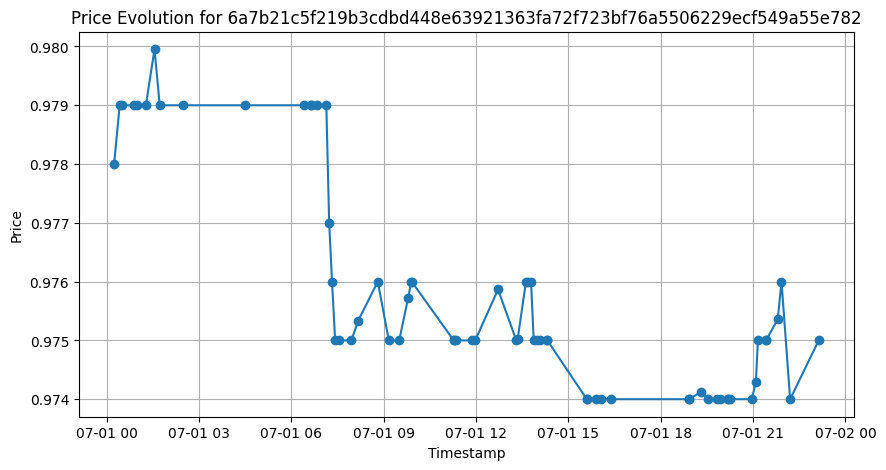

In [9]:
stockExchange.stocks["6a7b21c5f219b3cdbd448e63921363fa72f723bf76a5506229ecf549a55e782"].plot_prices()


In [10]:
people.people["0x000000000000000000000000b2d31d52b9272fe5d3caad2ed15a0b671e1f05e4"].get_total_return(stockExchange)

0.0037015879972084834

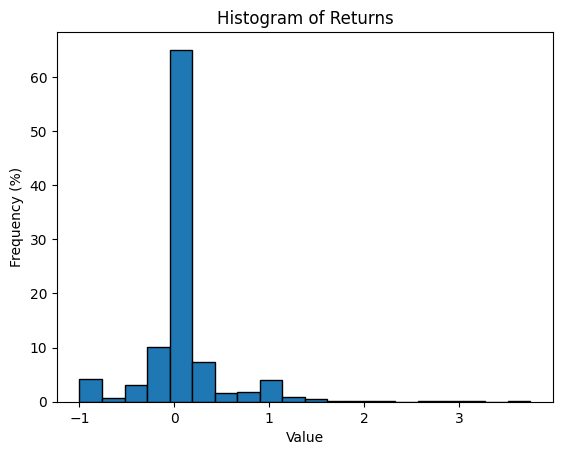

In [11]:
people.plot_returns(stockExchange)

In [12]:


with open("./people.pkl", "wb") as f:
    pickle.dump(people, f)



# saving objects (saves the whole dictionary of objects)
with open("./exchnage.pkl", "wb") as f:
    pickle.dump(stockExchange, f)

In [13]:
import matplotlib.pyplot as plt

# Example list of values


# Create histogram with percentage frequency
plt.hist(returns, bins=20, weights=[100/len(returns)]*len(returns), edgecolor='black')

# Add title and labels
plt.title('Histogram of Returns')
plt.xlabel('Value')
plt.ylabel('Frequency (%)')

# Show the plot
plt.show()


NameError: name 'returns' is not defined

In [ ]:
len(returns)

2059

In [ ]:
counter = 0

for re in returns:
    if re < 0:
        counter += 1


In [ ]:
counter

578

# Step 12 - working out Distribution!

In [ ]:
balances = []
for person in people:
    balances.append(people[person].get_portfolio_value(stockExchange) + people[person].balance)

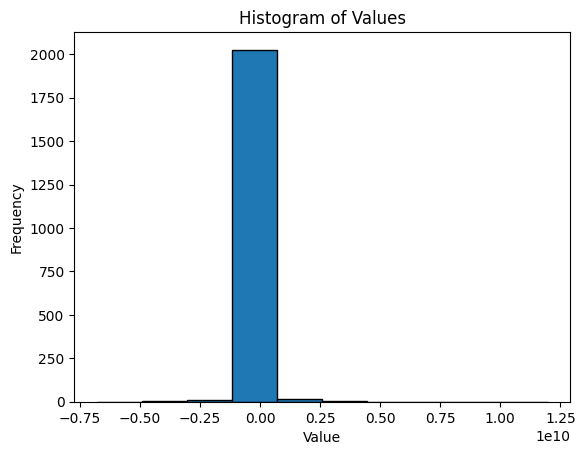

In [ ]:
import matplotlib.pyplot as plt

# Example list of values


# Create histogram
plt.hist(balances, bins=10, edgecolor='black')  # You can adjust the number of bins

# Add title and labels
plt.title('Histogram of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()


['a', 'b']